In [4]:
%matplotlib inline
import math
from decimal import *
import numpy as np # linear algebra
import pandas as pd # read_csv and such
import matplotlib.pyplot as plt # plotting and such
from geopy.distance import vincenty # calculate distance between locations
from io import StringIO # convert strings to buffers or something like that.
import seaborn as sns

pd.options.display.max_columns = 999

### Get the data and read into a dataframe

In [5]:
# the path to our flight + weather combined data set
flights_weather_path = '../data/flights_weather.csv'

In [6]:
flights_weather_df = pd.read_csv(flights_weather_path)
flights_weather_df.head()

,Unnamed: 0,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DATE,IATA_CODE_x,origin_weather_station,IATA_CODE_y,destination_weather_station,OR_TEMP,OR_COUNT_TEMP,OR_DEWP,OR_COUNT_DEWP,OR_SLP,OR_COUNT_SLP,OR_STP,OR_COUNT_STP,OR_VISIB,OR_COUNT_VISIB,OR_WDSP,OR_COUNT_WDSP,OR_MXSPD,OR_GUST,OR_MAX,OR_MIN,OR_PRCP,OR_SNDP,OR_FRSHTT,DES_TEMP,DES_COUNT_TEMP,DES_DEWP,DES_COUNT_DEWP,DES_SLP,DES_COUNT_SLP,DES_STP,DES_COUNT_STP,DES_VISIB,DES_COUNT_VISIB,DES_WDSP,DES_COUNT_WDSP,DES_MXSPD,DES_GUST,DES_MAX,DES_MIN,DES_PRCP,DES_SNDP,DES_FRSHTT
0,0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,ANC,702725-26491,SEA,727930-24233,35.1,24.0,30.7,24.0,1020.1,14.0,1015.2,24.0,7.5,24.0,3.6,24.0,6.0,999.9,43.0,32.0,0.09G,999.9,110000.0,32.9,24.0,22.2,24.0,1029.7,24.0,1012.7,24.0,10.0,24.0,4.6,24.0,11.1,999.9,42.1,26.1,0.00G,999.9,0.0
1,1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,LAX,722950-23174,PBI,722030-12844,47.1,24.0,22.5,24.0,1018.8,24.0,1007.2,24.0,10.0,24.0,5.5,24.0,15.0,999.9,57.0,36.0,0.00G,999.9,0.0,74.1,24.0,69.7,24.0,1021.1,22.0,1020.5,24.0,9.1,24.0,5.5,24.0,9.9,999.9,79.0,70.0,0.33G,999.9,10000.0
2,2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,SFO,724940-23234,CLT,723140-13881,49.5,24.0,30.9,24.0,1019.4,24.0,1018.8,24.0,10.0,24.0,7.8,24.0,15.0,999.9,57.9,39.9,0.00G,999.9,0.0,38.4,24.0,28.4,24.0,1026.8,24.0,998.5,24.0,9.7,24.0,2.3,24.0,7.0,999.9,53.1,26.1,0.00G,999.9,0.0
3,3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,LAX,722950-23174,MIA,722020-12839,47.1,24.0,22.5,24.0,1018.8,24.0,1007.2,24.0,10.0,24.0,5.5,24.0,15.0,999.9,57.0,36.0,0.00G,999.9,0.0,74.8,24.0,67.8,24.0,1021.3,24.0,1020.2,24.0,8.9,24.0,4.1,24.0,11.1,999.9,82.0,70.0,0.00G,999.9,0.0
4,4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,SEA,727930-24233,ANC,702725-26491,32.9,24.0,22.2,24.0,1029.7,24.0,1012.7,24.0,10.0,24.0,4.6,24.0,11.1,999.9,42.1,26.1,0.00G,999.9,0.0,35.1,24.0,30.7,24.0,1020.1,14.0,1015.2,24.0,7.5,24.0,3.6,24.0,6.0,999.9,43.0,32.0,0.09G,999.9,110000.0


In [17]:
# Drop the first column that has unneeded indexes
flights_weather_df = flights_weather_df.drop(flights_weather_df.columns[0], axis=1)
flights_weather_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DATE,IATA_CODE_x,origin_weather_station,IATA_CODE_y,destination_weather_station,OR_TEMP,OR_COUNT_TEMP,OR_DEWP,OR_COUNT_DEWP,OR_SLP,OR_COUNT_SLP,OR_STP,OR_COUNT_STP,OR_VISIB,OR_COUNT_VISIB,OR_WDSP,OR_COUNT_WDSP,OR_MXSPD,OR_GUST,OR_MAX,OR_MIN,OR_PRCP,OR_SNDP,OR_FRSHTT,DES_TEMP,DES_COUNT_TEMP,DES_DEWP,DES_COUNT_DEWP,DES_SLP,DES_COUNT_SLP,DES_STP,DES_COUNT_STP,DES_VISIB,DES_COUNT_VISIB,DES_WDSP,DES_COUNT_WDSP,DES_MXSPD,DES_GUST,DES_MAX,DES_MIN,DES_PRCP,DES_SNDP,DES_FRSHTT
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,ANC,702725-26491,SEA,727930-24233,35.1,24.0,30.7,24.0,1020.1,14.0,1015.2,24.0,7.5,24.0,3.6,24.0,6.0,999.9,43.0,32.0,0.09G,999.9,110000.0,32.9,24.0,22.2,24.0,1029.7,24.0,1012.7,24.0,10.0,24.0,4.6,24.0,11.1,999.9,42.1,26.1,0.00G,999.9,0.0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,LAX,722950-23174,PBI,722030-12844,47.1,24.0,22.5,24.0,1018.8,24.0,1007.2,24.0,10.0,24.0,5.5,24.0,15.0,999.9,57.0,36.0,0.00G,999.9,0.0,74.1,24.0,69.7,24.0,1021.1,22.0,1020.5,24.0,9.1,24.0,5.5,24.0,9.9,999.9,79.0,70.0,0.33G,999.9,10000.0
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,SFO,724940-23234,CLT,723140-13881,49.5,24.0,30.9,24.0,1019.4,24.0,1018.8,24.0,10.0,24.0,7.8,24.0,15.0,999.9,57.9,39.9,0.00G,999.9,0.0,38.4,24.0,28.4,24.0,1026.8,24.0,998.5,24.0,9.7,24.0,2.3,24.0,7.0,999.9,53.1,26.1,0.00G,999.9,0.0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,LAX,722950-23174,MIA,722020-12839,47.1,24.0,22.5,24.0,1018.8,24.0,1007.2,24.0,10.0,24.0,5.5,24.0,15.0,999.9,57.0,36.0,0.00G,999.9,0.0,74.8,24.0,67.8,24.0,1021.3,24.0,1020.2,24.0,8.9,24.0,4.1,24.0,11.1,999.9,82.0,70.0,0.00G,999.9,0.0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,SEA,727930-24233,ANC,702725-26491,32.9,24.0,22.2,24.0,1029.7,24.0,1012.7,24.0,10.0,24.0,4.6,24.0,11.1,999.9,42.1,26.1,0.00G,999.9,0.0,35.1,24.0,30.7,24.0,1020.1,14.0,1015.2,24.0,7.5,24.0,3.6,24.0,6.0,999.9,43.0,32.0,0.09G,999.9,110000.0


## Clean Up Weather Columns

Remove all weather columns related to COUNT. These values only specify a number of observations made and will not be correlative with the flight delays

In [18]:
# Drop the COUNT-related weather columns that only specify the number of observations (not correlated to delays) 
flights_weather_df = flights_weather_df.drop(['OR_COUNT_TEMP', 'OR_COUNT_DEWP', 'OR_COUNT_SLP', 'OR_COUNT_STP', 'OR_COUNT_VISIB', 'OR_COUNT_WDSP'], 1)
flights_weather_df = flights_weather_df.drop(['DES_COUNT_TEMP', 'DES_COUNT_DEWP', 'DES_COUNT_SLP', 'DES_COUNT_STP', 'DES_COUNT_VISIB', 'DES_COUNT_WDSP'], 1)
flights_weather_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DATE,IATA_CODE_x,origin_weather_station,IATA_CODE_y,destination_weather_station,OR_TEMP,OR_DEWP,OR_SLP,OR_STP,OR_VISIB,OR_WDSP,OR_MXSPD,OR_GUST,OR_MAX,OR_MIN,OR_PRCP,OR_SNDP,OR_FRSHTT,DES_TEMP,DES_DEWP,DES_SLP,DES_STP,DES_VISIB,DES_WDSP,DES_MXSPD,DES_GUST,DES_MAX,DES_MIN,DES_PRCP,DES_SNDP,DES_FRSHTT
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,ANC,702725-26491,SEA,727930-24233,35.1,30.7,1020.1,1015.2,7.5,3.6,6.0,999.9,43.0,32.0,0.09G,999.9,110000.0,32.9,22.2,1029.7,1012.7,10.0,4.6,11.1,999.9,42.1,26.1,0.00G,999.9,0.0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,LAX,722950-23174,PBI,722030-12844,47.1,22.5,1018.8,1007.2,10.0,5.5,15.0,999.9,57.0,36.0,0.00G,999.9,0.0,74.1,69.7,1021.1,1020.5,9.1,5.5,9.9,999.9,79.0,70.0,0.33G,999.9,10000.0
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,SFO,724940-23234,CLT,723140-13881,49.5,30.9,1019.4,1018.8,10.0,7.8,15.0,999.9,57.9,39.9,0.00G,999.9,0.0,38.4,28.4,1026.8,998.5,9.7,2.3,7.0,999.9,53.1,26.1,0.00G,999.9,0.0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,LAX,722950-23174,MIA,722020-12839,47.1,22.5,1018.8,1007.2,10.0,5.5,15.0,999.9,57.0,36.0,0.00G,999.9,0.0,74.8,67.8,1021.3,1020.2,8.9,4.1,11.1,999.9,82.0,70.0,0.00G,999.9,0.0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,SEA,727930-24233,ANC,702725-26491,32.9,22.2,1029.7,1012.7,10.0,4.6,11.1,999.9,42.1,26.1,0.00G,999.9,0.0,35.1,30.7,1020.1,1015.2,7.5,3.6,6.0,999.9,43.0,32.0,0.09G,999.9,110000.0


## Clean Up Flight Columns

For this analysis, we don't need some of the flight data that won't have any correlative significance with the weather (eg. flight number, tail number, etc.). Remove all of these unneeded columns

In [19]:
flights_weather_df = flights_weather_df.drop(['FLIGHT_NUMBER', 'TAIL_NUMBER', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'], axis=1)
flights_weather_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DATE,IATA_CODE_x,origin_weather_station,IATA_CODE_y,destination_weather_station,OR_TEMP,OR_DEWP,OR_SLP,OR_STP,OR_VISIB,OR_WDSP,OR_MXSPD,OR_GUST,OR_MAX,OR_MIN,OR_PRCP,OR_SNDP,OR_FRSHTT,DES_TEMP,DES_DEWP,DES_SLP,DES_STP,DES_VISIB,DES_WDSP,DES_MXSPD,DES_GUST,DES_MAX,DES_MIN,DES_PRCP,DES_SNDP,DES_FRSHTT
0,2015,1,1,4,AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,2015-01-01,ANC,702725-26491,SEA,727930-24233,35.1,30.7,1020.1,1015.2,7.5,3.6,6.0,999.9,43.0,32.0,0.09G,999.9,110000.0,32.9,22.2,1029.7,1012.7,10.0,4.6,11.1,999.9,42.1,26.1,0.00G,999.9,0.0
1,2015,1,1,4,AA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,2015-01-01,LAX,722950-23174,PBI,722030-12844,47.1,22.5,1018.8,1007.2,10.0,5.5,15.0,999.9,57.0,36.0,0.00G,999.9,0.0,74.1,69.7,1021.1,1020.5,9.1,5.5,9.9,999.9,79.0,70.0,0.33G,999.9,10000.0
2,2015,1,1,4,US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,2015-01-01,SFO,724940-23234,CLT,723140-13881,49.5,30.9,1019.4,1018.8,10.0,7.8,15.0,999.9,57.9,39.9,0.00G,999.9,0.0,38.4,28.4,1026.8,998.5,9.7,2.3,7.0,999.9,53.1,26.1,0.00G,999.9,0.0
3,2015,1,1,4,AA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,2015-01-01,LAX,722950-23174,MIA,722020-12839,47.1,22.5,1018.8,1007.2,10.0,5.5,15.0,999.9,57.0,36.0,0.00G,999.9,0.0,74.8,67.8,1021.3,1020.2,8.9,4.1,11.1,999.9,82.0,70.0,0.00G,999.9,0.0
4,2015,1,1,4,AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,2015-01-01,SEA,727930-24233,ANC,702725-26491,32.9,22.2,1029.7,1012.7,10.0,4.6,11.1,999.9,42.1,26.1,0.00G,999.9,0.0,35.1,30.7,1020.1,1015.2,7.5,3.6,6.0,999.9,43.0,32.0,0.09G,999.9,110000.0


### Clean up miscellaneous columns that are descriptive and non-numeric (won't be correlative)

In [25]:
flights_weather_df = flights_weather_df.drop(['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DATE', 'IATA_CODE_x', 'origin_weather_station', 'IATA_CODE_y', 'destination_weather_station'], axis=1)
flights_weather_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,OR_TEMP,OR_DEWP,OR_SLP,OR_STP,OR_VISIB,OR_WDSP,OR_MXSPD,OR_GUST,OR_MAX,OR_MIN,OR_PRCP,OR_SNDP,OR_FRSHTT,DES_TEMP,DES_DEWP,DES_SLP,DES_STP,DES_VISIB,DES_WDSP,DES_MXSPD,DES_GUST,DES_MAX,DES_MIN,DES_PRCP,DES_SNDP,DES_FRSHTT
0,2015,1,1,4,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,35.1,30.7,1020.1,1015.2,7.5,3.6,6.0,999.9,43.0,32.0,0.09G,999.9,110000.0,32.9,22.2,1029.7,1012.7,10.0,4.6,11.1,999.9,42.1,26.1,0.00G,999.9,0.0
1,2015,1,1,4,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,47.1,22.5,1018.8,1007.2,10.0,5.5,15.0,999.9,57.0,36.0,0.00G,999.9,0.0,74.1,69.7,1021.1,1020.5,9.1,5.5,9.9,999.9,79.0,70.0,0.33G,999.9,10000.0
2,2015,1,1,4,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,49.5,30.9,1019.4,1018.8,10.0,7.8,15.0,999.9,57.9,39.9,0.00G,999.9,0.0,38.4,28.4,1026.8,998.5,9.7,2.3,7.0,999.9,53.1,26.1,0.00G,999.9,0.0
3,2015,1,1,4,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,47.1,22.5,1018.8,1007.2,10.0,5.5,15.0,999.9,57.0,36.0,0.00G,999.9,0.0,74.8,67.8,1021.3,1020.2,8.9,4.1,11.1,999.9,82.0,70.0,0.00G,999.9,0.0
4,2015,1,1,4,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,32.9,22.2,1029.7,1012.7,10.0,4.6,11.1,999.9,42.1,26.1,0.00G,999.9,0.0,35.1,30.7,1020.1,1015.2,7.5,3.6,6.0,999.9,43.0,32.0,0.09G,999.9,110000.0


# Correlation Analysis of 2015 Flight Delays and Weather Data
---
We want to do a simple correlation analysis of the combined flight + weather dataset, and produce a heatmap of the variable correlaitons.

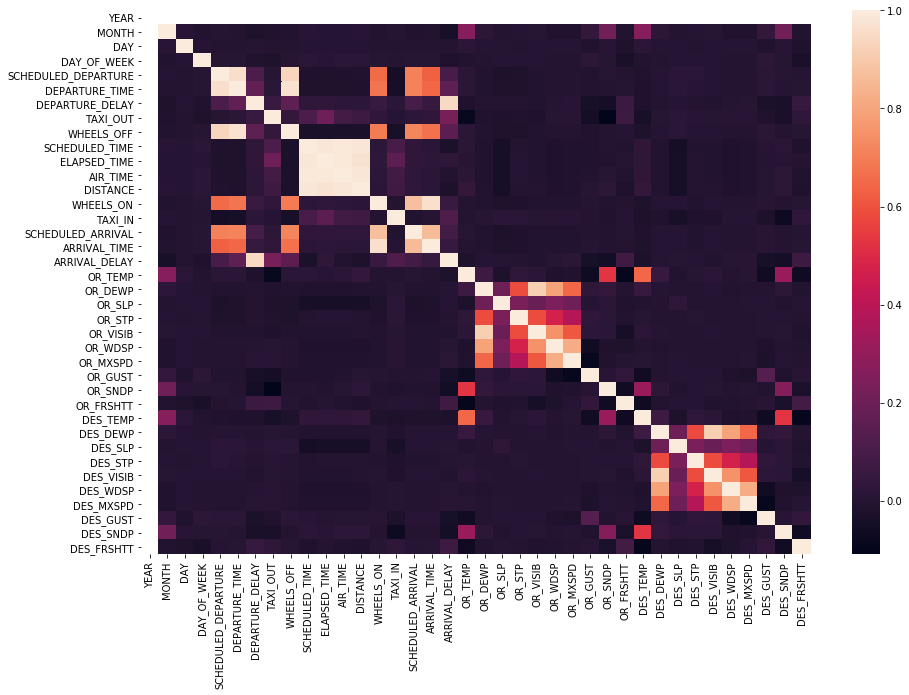

In [21]:
corr = flights_weather_df.corr()
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr,
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values,
           ax=ax)

In [22]:
corr

,YEAR,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,OR_TEMP,OR_DEWP,OR_SLP,OR_STP,OR_VISIB,OR_WDSP,OR_MXSPD,OR_GUST,OR_SNDP,OR_FRSHTT,DES_TEMP,DES_DEWP,DES_SLP,DES_STP,DES_VISIB,DES_WDSP,DES_MXSPD,DES_GUST,DES_SNDP,DES_FRSHTT
YEAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MONTH,NaN,1.000000,0.008874,-0.007847,0.000207,-0.004085,-0.021994,-0.013117,-0.004946,0.010784,0.001871,0.003379,0.011437,-0.008917,0.002095,-0.010121,-0.009133,-0.036793,0.266299,0.022474,-0.002923,0.003512,0.004034,-0.009858,-0.012635,0.039972,0.208562,-0.005651,0.266336,0.022473,-0.002937,0.003547,0.004021,-0.009885,-0.012632,0.039996,0.208569,-0.005534
DAY,NaN,0.008874,1.000000,0.001111,-0.001647,-0.002644,-0.000176,-0.002661,-0.003318,0.003403,0.001419,0.001923,0.003529,-0.004294,-0.001656,-0.003688,-0.004310,-0.003097,0.020874,0.000746,-0.000419,-0.001375,0.003175,0.002414,0.001715,-0.009323,0.011703,-0.021390,0.021017,0.000766,-0.000479,-0.001381,0.003178,0.002399,0.001710,-0.009290,0.011761,-0.021510
DAY_OF_WEEK,NaN,-0.007847,0.001111,1.000000,0.008007,0.005607,-0.011510,-0.020639,0.004060,0.014954,0.011510,0.014284,0.016516,0.005642,0.001111,0.007092,0.005641,-0.017027,-0.005663,-0.002317,0.003114,0.001437,0.001278,-0.002258,-0.002503,0.022912,0.007210,-0.031691,-0.005748,-0.002306,0.003239,0.001827,0.001289,-0.002263,-0.002543,0.022946,0.007176,-0.031705
SCHEDULED_DEPARTURE,NaN,0.000207,-0.001647,0.008007,1.000000,0.963791,0.110149,0.006581,0.938008,-0.016609,-0.017935,-0.015756,-0.009572,0.656098,-0.044719,0.706237,0.629342,0.100220,0.020918,-0.006676,-0.022956,-0.019479,-0.007503,-0.002613,-0.003269,-0.006973,0.004174,-0.003870,-0.012345,0.002775,0.017745,0.014736,0.003710,-0.003236,-0.002792,0.014230,0.004893,0.001240
DEPARTURE_TIME,NaN,-0.004085,-0.002644,0.005607,0.963791,1.000000,0.171723,0.014002,0.971971,-0.020851,-0.021990,-0.021146,-0.016492,0.675882,-0.040613,0.710223,0.648265,0.159787,0.016132,-0.006921,-0.022073,-0.018719,-0.008178,-0.002543,-0.002980,-0.008815,-0.001293,0.002063,-0.016989,0.001968,0.014485,0.008273,0.002839,-0.003134,-0.002324,0.013259,0.000368,0.005511
DEPARTURE_DELAY,NaN,-0.021994,-0.000176,-0.011510,0.110149,0.171723,1.000000,0.058515,0.162582,0.027799,0.030805,0.023495,0.024106,0.058674,0.012784,0.097566,0.049236,0.944672,-0.015897,-0.002190,-0.003120,-0.002586,-0.007267,0.001792,0.008711,-0.035365,-0.047624,0.062606,-0.014506,-0.001804,-0.000389,-0.000618,-0.006233,0.001950,0.007033,-0.026606,-0.034039,0.050092
TAXI_OUT,NaN,-0.013117,-0.002661,-0.020639,0.006581,0.014002,0.058515,1.000000,0.039104,0.112302,0.205195,0.087608,0.072333,0.032584,0.003221,0.024384,0.029745,0.227319,-0.084775,-0.010643,-0.017045,-0.011685,-0.014120,0.006722,0.010152,-0.047279,-0.108893,0.070765,-0.035677,0.007318,0.013484,0.009404,0.006094,0.010160,0.010151,-0.013027,-0.032990,0.027338
WHEELS_OFF,NaN,-0.004946,-0.003318,0.004060,0.938008,0.971971,0.162582,0.039104,1.000000,-0.028289,-0.027133,-0.029654,-0.027586,0.695734,-0.038814,0.721877,0.667991,0.155773,0.013426,-0.006918,-0.021621,-0.018063,-0.008334,-0.001981,-0.002695,-0.010480,-0.004497,0.003635,-0.019249,0.002184,0.012791,0.003493,0.003230,-0.002760,-0.002010,0.013819,-0.000678,0.005759
SCHEDULED_TIME,NaN,0.010784,0.003403,0.014954,-0.016609,-0.020851,0.027799,0.112302,-0.028289,1.000000,0.985260,0.990749,0.984336,0.023414,0.099036,0.031963,0.020439,-0.030029,0.013244,-0.011194,-0.043591,-0.000927,-0.009194,-0.015431,-0.012297,-0.009754,-0.001705,-0.008728,0.033994,-0.008510,-0.044853,-0.005574,-0.006224,-0.017826,-0.012938,0.009612,0.020576,-0.016572
